# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based autoencoder.**

In [2]:
!pip install -r requirements.txt | grep -v "already"

Defaulting to user installation because normal site-packages is not writeable


> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

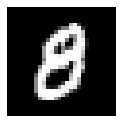

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [14]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 2, stride = 2),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

## Loss Function

Set up here a loss function that makes sense for the task at hand (look at the lesson again if you don't remember what this should be):

In [15]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

Complete the training loop below. As usual, you need to perform the forward and the backward pass.

In [16]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [17]:
print("Input shape:", images.shape)
print("Output shape:", outputs.shape)
print("Flattened input size:", images.flatten().size(0))
print("Flattened output size:", outputs.flatten().size(0))

Input shape: torch.Size([1024, 1, 28, 28])
Output shape: torch.Size([1024, 1, 25, 25])
Flattened input size: 802816
Flattened output size: 640000


In [18]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # YOUR CODE HERE
        # Clear gradients for all optimized gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass
        loss.backward()
        # single optimization step to update parameter
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch: 1 	Training Loss: 117.215710	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 2 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.08s/it]


Epoch: 3 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


Epoch: 4 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Epoch: 5 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Epoch: 6 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]


Epoch: 7 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.02s/it]


Epoch: 8 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 9 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch: 10 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


Epoch: 11 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


Epoch: 12 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.14s/it]


Epoch: 13 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Epoch: 14 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


Epoch: 15 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


Epoch: 16 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.92s/it]


Epoch: 17 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.11s/it]


Epoch: 18 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]


Epoch: 19 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 20 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch: 21 	Training Loss: 114.430366	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch: 22 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 23 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 24 	Training Loss: 114.430366	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Epoch: 25 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.71s/it]


Epoch: 26 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch: 27 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.08s/it]


Epoch: 28 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Epoch: 29 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Epoch: 30 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 31 	Training Loss: 114.430366	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


Epoch: 32 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


Epoch: 33 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]


Epoch: 34 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch: 35 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch: 36 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


Epoch: 37 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch: 38 	Training Loss: 114.430364	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]


Epoch: 39 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch: 40 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


Epoch: 41 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch: 42 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch: 43 	Training Loss: 114.430366	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 44 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch: 45 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


Epoch: 46 	Training Loss: 114.430365	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 47 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch: 48 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


Epoch: 49 	Training Loss: 114.430363	Valid Loss: 111.827295


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]

Epoch: 50 	Training Loss: 114.430365	Valid Loss: 111.827295


In [19]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [20]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


,loss,image,reconstructed
0,0.07547,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0.123943,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,0.039161,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,0.165589,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,0.078105,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

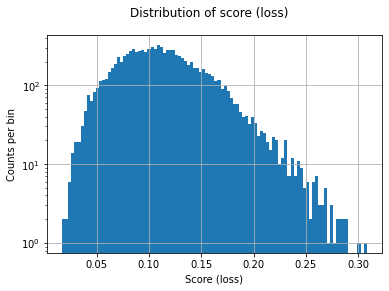

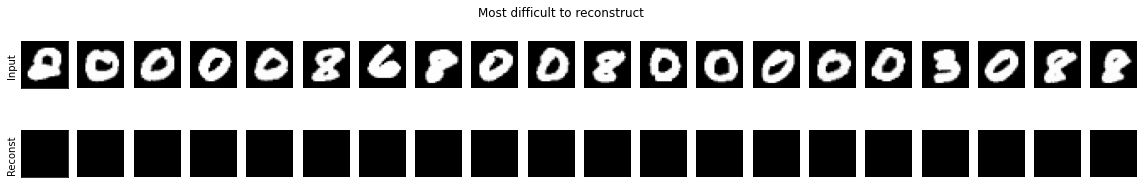

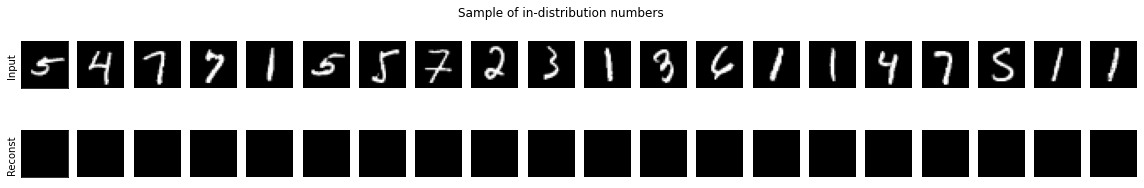

In [21]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear autoencoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).